In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import carna.py as cpy
import skimage.io
import scipy.ndimage as ndi

In [3]:
print(f'Carna {cpy.version} (CarnaPy {cpy.py_version})')

Carna 3.3.1 (CarnaPy 0.1.1)


# Example data

**3D microscopy data used for examples:** [*Kalinin, A.A., Allyn-Feuer, A., Ade, A., Fon, G.V., Meixner, W., Dilworth, D., Jeffrey, R., Higgins, G.A., Zheng, G., Creekmore, A., et al., 2018. 3D cell nuclear morphology: Microscopy imaging dataset and voxel-based morphometry classification results, in: Proceedings of the Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), IEEE. pp. 2272–2280.*](http://www.socr.umich.edu/projects/3d-cell-morphometry/data.html)

Image from a 3D stack, annotated with some example markers:

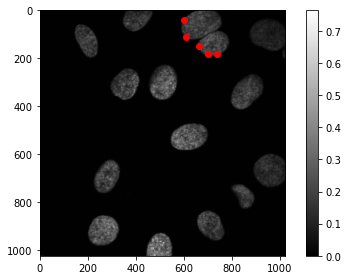

In [4]:
data = skimage.io.imread('../../testdata/08_06_NormFibro_Fibrillarin_of_07_31_Slide2_num2_c0_g006.tif').T
data = data / data.max()

markers = array([
    [ 40, 600, 15],
    [110, 610, 15],
    [150, 665, 15],
    [180, 700, 15],
    [180, 740, 15],
])

imshow(data[:,:, 15], 'gray')
colorbar()
scatter(*markers[:,:-1][:,::-1].T, c='r')
tight_layout()

The z-spacing is unknown, so we will just assume that z-resolution is 4 times lower than x-/y-resolution:

In [5]:
spacing = (1, 1, 4)

# Direct volume rendering

**Example 1.** Use `dvr` to issue a direct volume rendering:

/home/void/.anaconda3/envs/carna/lib/python3.8/site-packages/carna/py.py:71: UserWarning: Unsupported data type: float64 (will be treated as float16)
  warnings.warn(f'Unsupported data type: {dtype} (will be treated as {dtype_fallback})')


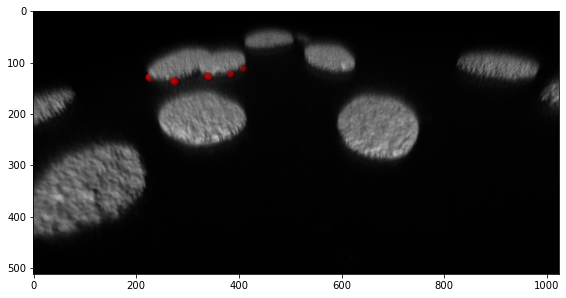

In [6]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, normals=True) ## declaration of the volume data
    rc.dvr(translucency=2, sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, volume.map_voxel_coordinates(markers), parent=volume)
    rc.camera.rotate((1,1,0), 45, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 300).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

Remember to pass `normals=True` to the declaration of the volume data via `volume` to issue a computation of the normal vectors, which is required to perform lighting. Also, note that the `dtype` of data is `float64`:

In [7]:
data.dtype

dtype('float64')

However, the data is only 8bit, but `skimage.io` converts it into 64bit when loading. This is okay for system memory, but video memory is usaully rather limited, and although Carna currently only supports 8bit and 16bit volume data, wasting factor 2 is not very appealing. This is what the above warning indicates. To circuvent, simply use the `fmt_hint` parameter for the volume declaration:

**Example 2.** Use `fmt_hint='uint8'` to suggest 8bit volume data representation:

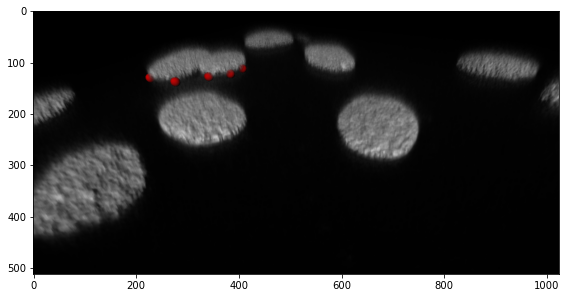

In [8]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, normals=True, fmt_hint='uint8') ## declaration of the volume data
    rc.dvr(translucency=2, sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, volume.map_voxel_coordinates(markers), parent=volume)
    rc.camera.rotate((1,1,0), 45, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 300).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

**Example 3.** You can also use a more sophisticated color map, like $[0,0.2) \mapsto$ teal and $[0.4,1] \mapsto$ yellow:

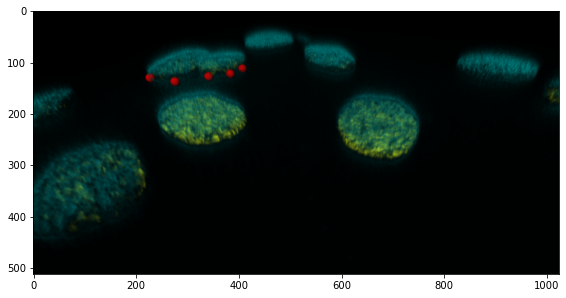

In [9]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, normals=True, fmt_hint='uint8') ## declaration of the volume data
    rc.dvr(color_map=[(0, 0.2, (0, 1, 1, 0), (0, 1, 1, 0.2)), (0.4, 1.0, (1, 1, 0, 0), (1, 1, 0, 1))], translucency=2, sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, volume.map_voxel_coordinates(markers), parent=volume)
    rc.camera.rotate((1,1,0), 45, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 300).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

**Example 4.** Direct volume rendering can also be performed without lighting:

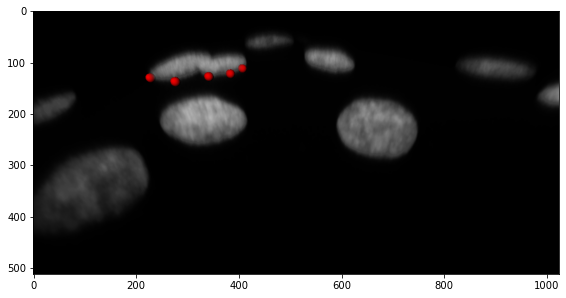

In [10]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, fmt_hint='uint8')
    rc.dvr(translucency=20, sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, volume.map_voxel_coordinates(markers), parent=volume)
    rc.camera.rotate((1,1,0), 45, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 300).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

Omitting `normals=True` if lighting is not required speeds up the `volume` command but produces less realistic renderings.

# Maximum intensity projection

**Example 5.** Use `rc.mip` to specify a maximum instensity projection:

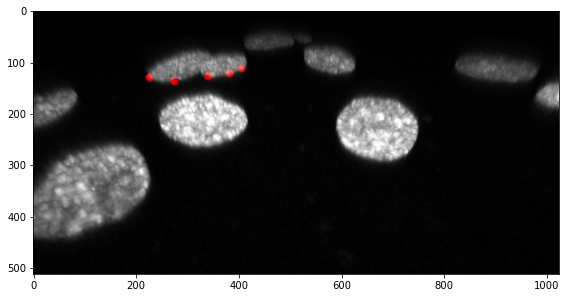

In [11]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, fmt_hint='uint8')
    rc.mip(sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, volume.map_voxel_coordinates(markers), parent=volume)
    rc.camera.rotate((1,1,0), 45, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 300).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

**Example 6.** Use the `layers` parameter of `rc.mip` to specify the color map and/or multiple layers.

In this example, intensities $[0,0.2)$ are mapped linearly to blue, whereas intensities $[0.4, 1]$ are mapped linearly to yellow:

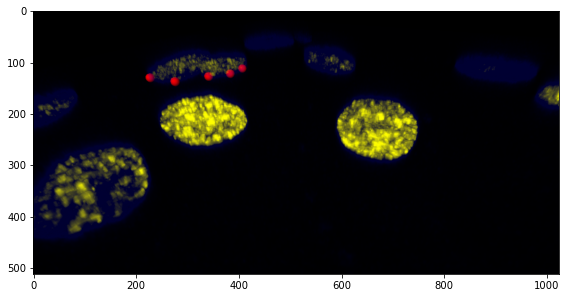

In [12]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, fmt_hint='uint8')
    rc.mip(layers=[(0, 0.2, (0, 0, 1, 0.2)), (0.4, 1, (1, 1, 0, 1))], sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, volume.map_voxel_coordinates(markers), parent=volume)
    rc.camera.rotate((1,1,0), 45, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 300).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

# Cutting plane rendering

**Example 7.** Use `rc.plane` to define cutting planes:

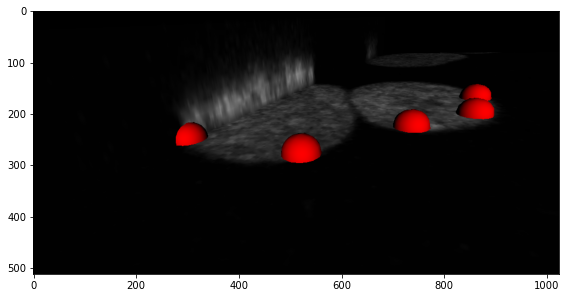

In [13]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, fmt_hint='uint8')
    markers_in_volume = volume.map_voxel_coordinates(markers)
    rc.plane((0,0,1), markers_in_volume[0], parent=volume) ## plane through first marker, normal along z-axis
    rc.plane((1,0,0), markers_in_volume[0], parent=volume) ## plane through first marker, normal along x-axis
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_in_volume, parent=volume)
    rc.camera.rotate((1,1,0), 55, 'deg').rotate((1,0,0), 15, 'deg').translate(-300, -80, -150).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

**Example 8.** Add `rc.occluded()` to visualize visually occluded geometry: (note that the markers are half-translucent)

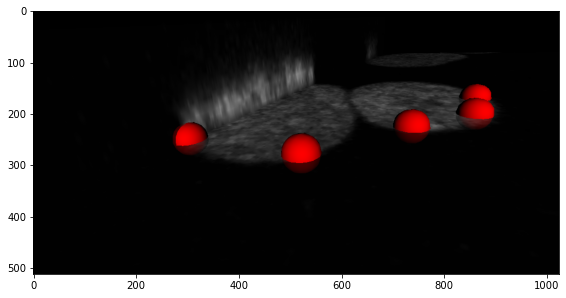

In [14]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, fmt_hint='uint8')
    markers_in_volume = volume.map_voxel_coordinates(markers)
    rc.plane((0,0,1), markers_in_volume[0], parent=volume) ## plane through first marker, normal along z-axis
    rc.plane((1,0,0), markers_in_volume[0], parent=volume) ## plane through first marker, normal along x-axis
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_in_volume, parent=volume)
    rc.occluded()
    rc.camera.rotate((1,1,0), 55, 'deg').rotate((1,0,0), 15, 'deg').translate(-300, -80, -150).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

# Combining different visualization techniques

**Example 9.** This example shows the combination of maximum intensity projection and cutting planes: (the markers are left out for clarity)

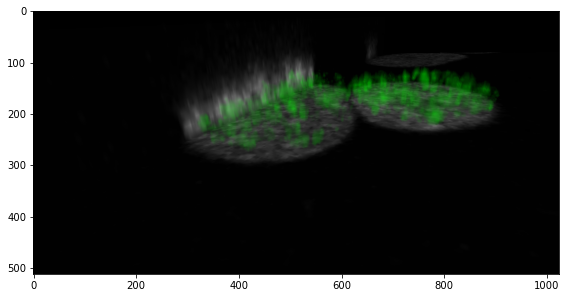

In [15]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    volume = rc.volume(data, spacing=spacing, fmt_hint='uint8')
    markers_in_volume = volume.map_voxel_coordinates(markers)
    rc.plane((0,0,1), markers_in_volume[0], parent=volume) ## plane through first marker, normal along z-axis
    rc.plane((1,0,0), markers_in_volume[0], parent=volume) ## plane through first marker, normal along x-axis
    rc.mip(layers=[(0.4, 1, (0, 1, 0, 1))], sample_rate=500)
    rc.camera.rotate((1,1,0), 55, 'deg').rotate((1,0,0), 15, 'deg').translate(-300, -80, -150).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

**Example 10.** 3D masks can also be rendered:

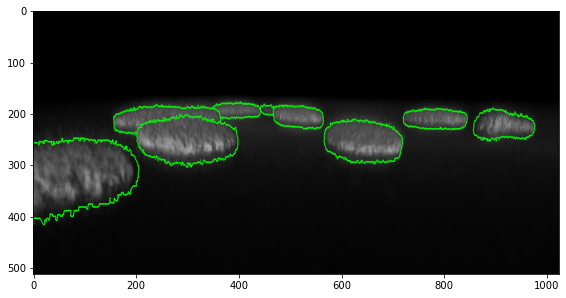

In [16]:
with cpy.SingleFrameContext((512, 1024), fov=90, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing, normals=True, fmt_hint='uint8') ## declaration of the volume data
    rc.dvr(translucency=2, sample_rate=500)
    rc.mask(ndi.label(ndi.binary_opening(data > 0.06))[0], 'borders-on-top', spacing=spacing)
    rc.camera.rotate((2,1,0), 65, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 300).rotate((0,0,1), 25, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

Different flavors of mask renderings are available:
- `borders-on-top`: Borders are rendered above the image (see above)
- `regions-on-top`: Mask regions are rendered above the image
- `borders-in-background`: The borders are rendered in the background
- `regions`: The 3D regions are rendered as solid objects

The mask used for rendering can be either a binary mask or a gray-value mask (e.g., to identify individual objects).